# Data Preprocessing and Feature Engineering

## Overview
This notebook handles data cleaning, preprocessing, and feature engineering to prepare the data for machine learning models.

## Contents
1. Data Loading and Initial Preprocessing
2. Handling Missing Values
3. Merging Administrative and Laboratory Data
4. Feature Engineering
5. Creating Risk Indicators
6. Final Dataset Preparation
7. Saving Processed Data

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings

sys.path.append('scripts')

from data_loader import load_hospital_data, data_quality_report
from preprocessing import (
    preprocess_admin_data, preprocess_lab_data, handle_lab_duplicates,
    impute_lab_values, pivot_lab_to_wide, merge_admin_lab_data,
    create_temporal_features, create_lab_aggregates, create_risk_indicators,
    handle_missing_values
)
from visualization import plot_numerical_distribution

warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load Data

In [2]:
admin, lab = load_hospital_data(
    admin_site1_path='input/administrative_site1.csv',
    admin_site2_path='input/administrative_site2.csv',
    lab_path='input/lab.csv'
)

print(f"Administrative data loaded: {admin.shape}")
print(f"Laboratory data loaded: {lab.shape}")

Administrative data loaded: (2000, 9)
Laboratory data loaded: (3000, 8)


## 3. Initial Data Quality Assessment

In [3]:
admin_report = data_quality_report(admin, "Administrative Data - Raw")
lab_report = data_quality_report(lab, "Laboratory Data - Raw")


DATA QUALITY REPORT: Administrative Data - Raw

Total Records: 2,000
Total Features: 9
Memory Usage: 0.80 MB

---------------------------------Missing Values---------------------------------
        Missing Count  Percentage
age               400        20.0
gender            300        15.0

-------------------------------Duplicate Records--------------------------------
Number of duplicate rows: 0 (0.00%)

-----------------------------------Data Types-----------------------------------
object     6
int64      2
float64    1
Name: count, dtype: int64

DATA QUALITY REPORT: Laboratory Data - Raw

Total Records: 3,000
Total Features: 8
Memory Usage: 1.18 MB

---------------------------------Missing Values---------------------------------
No missing values found!

-------------------------------Duplicate Records--------------------------------
Number of duplicate rows: 0 (0.00%)

-----------------------------------Data Types-----------------------------------
object     6
int64      1
fl

## 4. Preprocess Administrative Data

In [4]:
admin_processed = preprocess_admin_data(admin)

print("\nAdministrative Data - After Preprocessing:")
print(admin_processed.head())
print(f"\nNew columns created: {list(set(admin_processed.columns) - set(admin.columns))}")


Administrative Data - After Preprocessing:
     ID admission_date admission_time discharge_date discharge_time  \
0  1003     2002-04-25          07:47     2002-05-08          12:02   
1  1008     2004-09-02          07:49     2005-02-01          10:07   
2  1009     2011-01-01          17:08     2011-06-26          08:16   
3  1019     2000-03-09          10:15     2000-05-29          22:38   
4  1030     2003-11-18          08:31     2004-01-28          13:21   

                  hospital_ID gender   age  disease_status  length_of_stay  \
0  St. Joseph's Health Centre      F   NaN               0              13   
1      St. Michael's Hospital      M  58.0               0             152   
2      St. Michael's Hospital    NaN   NaN               1             176   
3      St. Michael's Hospital      M   NaN               1              81   
4      St. Michael's Hospital      F  72.0               0              71   

   admission_year  admission_month  admission_day_of_week  a

## 5. Preprocess Laboratory Data

In [5]:
lab_processed = preprocess_lab_data(lab)

print("\nLaboratory Data - After Preprocessing:")
print(lab_processed.head())
print(f"\nNew columns created: {list(set(lab_processed.columns) - set(lab.columns))}")


Laboratory Data - After Preprocessing:
     ID          test_name test_code result_unit  result_value result_date  \
0  1003      Sodium plasma      NAPL      mmol/L         137.0  2002-05-07   
1  1003  Creatinine plasma    CREAPL      umol/L         537.0  2002-05-02   
2  1005        Urea plasma    UREAPL      mmol/L          37.3  2005-12-04   
3  1008      Sodium plasma      NAPL      mmol/L         143.1  2004-10-19   
4  1008        Urea plasma    UREAPL      mmol/L          13.0  2004-11-05   

  result_time      provider_name  result_year  result_month  
0       05:26        Wray, Jamie         2002             5  
1       02:02    Young, Jennifer         2002             5  
2       16:02     Glass, Caitlin         2005            12  
3       04:17      Wilbur, Kurra         2004            10  
4       13:58  PREMOVICH, TAYLOR         2004            11  

New columns created: ['result_month', 'result_year']


## 6. Handle Duplicate Lab Tests

When a patient has multiple tests of the same type, we keep the lowest value (most conservative approach for risk assessment).

In [6]:
print(f"Lab records before handling duplicates: {len(lab_processed)}")

lab_cleaned = handle_lab_duplicates(lab_processed, strategy='lowest')

print(f"Lab records after handling duplicates: {len(lab_cleaned)}")
print(f"Duplicate tests removed: {len(lab_processed) - len(lab_cleaned)}")

Lab records before handling duplicates: 3000
Lab records after handling duplicates: 2718
Duplicate tests removed: 282


## 7. Impute Missing Laboratory Values

We'll mark year 2002 data as missing and impute with mean values for demonstration.

In [7]:
print("Missing values before imputation:")
print(lab_cleaned['result_value'].isna().sum())

lab_imputed = impute_lab_values(lab_cleaned, impute_year=2002, strategy='mean')

print("\nMissing values after imputation:")
print(lab_imputed['result_value'].isna().sum())

print("\nImputation summary by test:")
for test_name in lab_imputed['test_name'].unique():
    test_data = lab_imputed[lab_imputed['test_name'] == test_name]
    print(f"  {test_name}: mean = {test_data['result_value'].mean():.2f}")

Missing values before imputation:
0

Missing values after imputation:
0

Imputation summary by test:
  Sodium plasma: mean = 134.04
  Creatinine plasma: mean = 317.00
  Urea plasma: mean = 72.44
  Chloride plasma: mean = 129.56
  Potassium plasma: mean = 6.30
  Bicarbonate plasma: mean = 55.90


## 8. Convert Laboratory Data to Wide Format

In [8]:
lab_wide = pivot_lab_to_wide(lab_imputed)

print("Laboratory Data - Wide Format:")
print(f"Shape: {lab_wide.shape}")
print(f"\nColumns: {list(lab_wide.columns)}")
print(f"\nFirst few rows:")
print(lab_wide.head())

print(f"\nMissing values per test:")
print(lab_wide.isna().sum())

Laboratory Data - Wide Format:
Shape: (1820, 6)

Columns: ['Bicarbonate plasma', 'Chloride plasma', 'Creatinine plasma', 'Potassium plasma', 'Sodium plasma', 'Urea plasma']

First few rows:
test_name  Bicarbonate plasma  Chloride plasma  Creatinine plasma  \
ID                                                                  
1003                      NaN              NaN         317.004959   
1005                      NaN              NaN                NaN   
1008                      NaN              NaN                NaN   
1009                      NaN              NaN          73.100000   
1019                      NaN             77.3         367.900000   

test_name  Potassium plasma  Sodium plasma  Urea plasma  
ID                                                       
1003                    NaN     134.038331          NaN  
1005                    NaN            NaN         37.3  
1008                    NaN     143.100000         13.0  
1009                    NaN     145.

## 9. Merge Administrative and Laboratory Data

In [9]:
merged_data = merge_admin_lab_data(admin_processed, lab_wide, how='left')

print(f"Merged dataset shape: {merged_data.shape}")
print(f"\nColumns: {list(merged_data.columns)}")
print(f"\nFirst few rows:")
print(merged_data.head())

print(f"\nMissing values summary:")
missing_summary = merged_data.isna().sum()[merged_data.isna().sum() > 0]
print(missing_summary)

Merged dataset shape: (2000, 20)

Columns: ['ID', 'admission_date', 'admission_time', 'discharge_date', 'discharge_time', 'hospital_ID', 'gender', 'age', 'disease_status', 'length_of_stay', 'admission_year', 'admission_month', 'admission_day_of_week', 'admission_quarter', 'Bicarbonate plasma', 'Chloride plasma', 'Creatinine plasma', 'Potassium plasma', 'Sodium plasma', 'Urea plasma']

First few rows:
     ID admission_date admission_time discharge_date discharge_time  \
0  1003     2002-04-25          07:47     2002-05-08          12:02   
1  1008     2004-09-02          07:49     2005-02-01          10:07   
2  1009     2011-01-01          17:08     2011-06-26          08:16   
3  1019     2000-03-09          10:15     2000-05-29          22:38   
4  1030     2003-11-18          08:31     2004-01-28          13:21   

                  hospital_ID gender   age  disease_status  length_of_stay  \
0  St. Joseph's Health Centre      F   NaN               0              13   
1      St. Mi

## 10. Create Temporal Features

In [10]:
merged_data = create_temporal_features(merged_data)

print("Temporal features created:")
temporal_features = ['is_weekend_admission', 'is_winter', 'is_spring', 'is_summer', 'is_fall']
print(merged_data[temporal_features].head(10))

print("\nTemporal feature distributions:")
for feature in temporal_features:
    print(f"  {feature}: {merged_data[feature].value_counts().to_dict()}")

Temporal features created:
   is_weekend_admission  is_winter  is_spring  is_summer  is_fall
0                     0          0          1          0        0
1                     0          0          0          0        1
2                     1          1          0          0        0
3                     0          0          1          0        0
4                     0          0          0          0        1
5                     0          0          0          0        1
6                     1          0          0          1        0
7                     0          0          0          0        1
8                     1          0          0          1        0
9                     0          1          0          0        0

Temporal feature distributions:
  is_weekend_admission: {0: 1454, 1: 546}
  is_winter: {0: 1509, 1: 491}
  is_spring: {0: 1505, 1: 495}
  is_summer: {0: 1498, 1: 502}
  is_fall: {0: 1488, 1: 512}


## 11. Create Laboratory Aggregate Features

In [11]:
lab_columns = [
    'Bicarbonate plasma', 'Chloride plasma', 'Creatinine plasma',
    'Potassium plasma', 'Sodium plasma', 'Urea plasma'
]

merged_data = create_lab_aggregates(merged_data, lab_columns)

print("Laboratory aggregate features created:")
aggregate_features = ['lab_test_count', 'lab_mean_value', 'lab_std_value', 
                      'lab_max_value', 'lab_min_value', 'lab_range']
print(merged_data[aggregate_features].describe())

Laboratory aggregate features created:
       lab_test_count  lab_mean_value  lab_std_value  lab_max_value  \
count     2000.000000     1820.000000     802.000000    1820.000000   
mean         1.359000      124.756333      88.653200     154.046240   
std          0.711598       95.141214      78.712681     120.050476   
min          0.000000        0.100000       0.141421       0.100000   
25%          1.000000       70.775000      38.590353      97.700000   
50%          1.000000      119.700000      66.927657     132.900000   
75%          2.000000      142.000000      99.401536     148.325000   
max          3.000000      593.800000     402.273048     598.700000   

       lab_min_value    lab_range  
count    1820.000000  1820.000000  
mean       96.379882    57.666358  
std        94.986922   100.973399  
min         0.100000     0.000000  
25%        18.200000     0.000000  
50%        87.850000     0.000000  
75%       133.800000    87.975000  
max       593.800000   568.900000

## 12. Create Clinical Risk Indicators

In [12]:
merged_data = create_risk_indicators(merged_data)

risk_features = [col for col in merged_data.columns if any(x in col for x in ['_high', '_low', '_abnormal'])]
print(f"Risk indicator features created: {len(risk_features)}")
print(risk_features)

print("\nRisk indicator distributions:")
for feature in risk_features:
    count = merged_data[feature].sum()
    pct = (count / len(merged_data)) * 100
    print(f"  {feature}: {count} ({pct:.1f}%)")

Risk indicator features created: 12
['creatinine_high', 'sodium_low', 'sodium_high', 'sodium_abnormal', 'potassium_low', 'potassium_high', 'potassium_abnormal', 'urea_high', 'chloride_low', 'chloride_high', 'bicarbonate_low', 'bicarbonate_high']

Risk indicator distributions:
  creatinine_high: 341 (17.1%)
  sodium_low: 523 (26.2%)
  sodium_high: 120 (6.0%)
  sodium_abnormal: 643 (32.1%)
  potassium_low: 42 (2.1%)
  potassium_high: 262 (13.1%)
  potassium_abnormal: 304 (15.2%)
  urea_high: 291 (14.5%)
  chloride_low: 70 (3.5%)
  chloride_high: 225 (11.2%)
  bicarbonate_low: 21 (1.1%)
  bicarbonate_high: 248 (12.4%)


## 13. Analyze Risk Indicators by Disease Status

Risk Indicators by Disease Status (% of patients):
disease_status              0          1
creatinine_high     16.666667  17.453799
sodium_low          26.705653  25.564682
sodium_high          5.945419   6.057495
sodium_abnormal     32.651072  31.622177
potassium_low        1.851852   2.361396
potassium_high      12.573099  13.655031
potassium_abnormal  14.424951  16.016427
urea_high           15.107212  13.963039
chloride_low         2.923977   4.106776
chloride_high       11.695906  10.780287
bicarbonate_low      0.974659   1.129363
bicarbonate_high    12.475634  12.320329


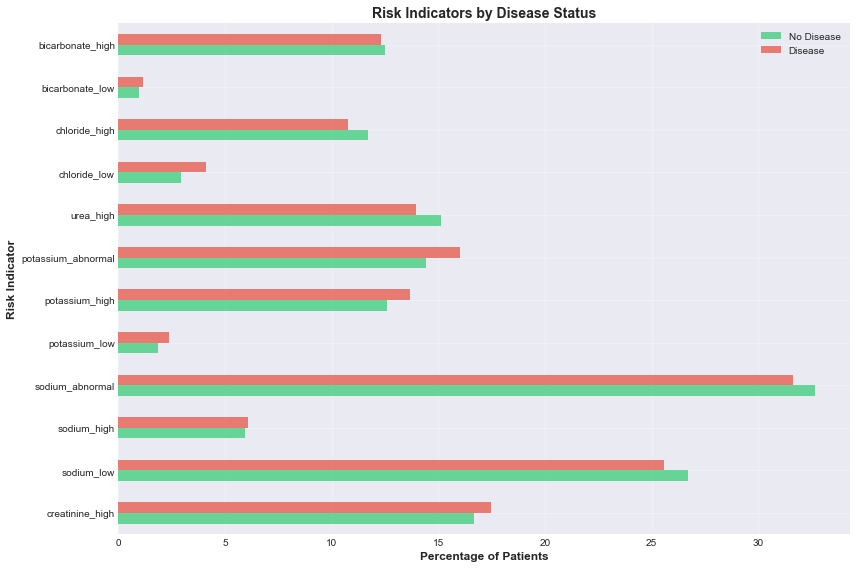

In [13]:
risk_by_disease = merged_data.groupby('disease_status')[risk_features].mean() * 100

print("Risk Indicators by Disease Status (% of patients):")
print(risk_by_disease.T)

fig, ax = plt.subplots(figsize=(12, 8))
risk_by_disease.T.plot(kind='barh', ax=ax, color=['#2ecc71', '#e74c3c'], alpha=0.7)
ax.set_xlabel('Percentage of Patients', fontsize=12, fontweight='bold')
ax.set_ylabel('Risk Indicator', fontsize=12, fontweight='bold')
ax.set_title('Risk Indicators by Disease Status', fontsize=14, fontweight='bold')
ax.legend(['No Disease', 'Disease'])
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Handle Missing Values in Final Dataset

In [14]:
print("Missing values before handling:")
print(merged_data.isna().sum()[merged_data.isna().sum() > 0])

merged_data_filled = handle_missing_values(
    merged_data,
    numerical_strategy='median',
    categorical_strategy='mode'
)

print("\nMissing values after handling:")
print(merged_data_filled.isna().sum()[merged_data_filled.isna().sum() > 0])

print(f"\nFinal dataset shape: {merged_data_filled.shape}")

Missing values before handling:
gender                 300
age                    400
Bicarbonate plasma    1708
Chloride plasma       1684
Creatinine plasma     1602
Potassium plasma      1609
Sodium plasma         1111
Urea plasma           1568
lab_mean_value         180
lab_std_value         1198
lab_max_value          180
lab_min_value          180
lab_range              180
dtype: int64

Missing values after handling:
Series([], dtype: int64)

Final dataset shape: (2000, 43)


## 15. Feature Summary

In [15]:
print("="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

print(f"\nTotal features created: {merged_data_filled.shape[1]}")

print("\nFeature categories:")
print(f"  • Original administrative features: {len(admin.columns)}")
print(f"  • Laboratory test features: {len(lab_columns)}")
print(f"  • Temporal features: {len(temporal_features)}")
print(f"  • Laboratory aggregate features: {len(aggregate_features)}")
print(f"  • Clinical risk indicators: {len(risk_features)}")

numerical_features = merged_data_filled.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = merged_data_filled.select_dtypes(include=['object']).columns.tolist()

print(f"\n  • Numerical features: {len(numerical_features)}")
print(f"  • Categorical features: {len(categorical_features)}")

print("\nData Types:")
print(merged_data_filled.dtypes.value_counts())

print("\n" + "="*80)

FEATURE ENGINEERING SUMMARY

Total features created: 43

Feature categories:
  • Original administrative features: 9
  • Laboratory test features: 6
  • Temporal features: 5
  • Laboratory aggregate features: 6
  • Clinical risk indicators: 12

  • Numerical features: 37
  • Categorical features: 4

Data Types:
int64             21
float64           12
object             4
int32              4
datetime64[ns]     2
Name: count, dtype: int64



## 16. Save Processed Data

In [16]:
import os

output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

merged_data_filled.to_csv(f'{output_dir}/processed_data.csv', index=False)
print(f"Processed data saved to: {output_dir}/processed_data.csv")

feature_info = pd.DataFrame({
    'Feature': merged_data_filled.columns,
    'Data Type': [merged_data_filled[col].dtype for col in merged_data_filled.columns],
    'Missing Values': [merged_data_filled[col].isna().sum() for col in merged_data_filled.columns],
    'Unique Values': [merged_data_filled[col].nunique() for col in merged_data_filled.columns]
})

feature_info.to_csv(f'{output_dir}/feature_info.csv', index=False)
print(f"Feature information saved to: {output_dir}/feature_info.csv")

print("\nPreprocessing complete!")

Processed data saved to: output/processed_data.csv
Feature information saved to: output/feature_info.csv

Preprocessing complete!


## 17. Final Data Quality Check

In [17]:
final_report = data_quality_report(merged_data_filled, "Final Processed Dataset")

print("\nDataset is ready for machine learning modeling!")


DATA QUALITY REPORT: Final Processed Dataset

Total Records: 2,000
Total Features: 43
Memory Usage: 1.07 MB

---------------------------------Missing Values---------------------------------
No missing values found!

-------------------------------Duplicate Records--------------------------------
Number of duplicate rows: 0 (0.00%)

-----------------------------------Data Types-----------------------------------
int64             21
float64           12
object             4
int32              4
datetime64[ns]     2
Name: count, dtype: int64

Dataset is ready for machine learning modeling!
